In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src") 

import numpy as np
from axitra import *
import matplotlib.pyplot as pt
#%matplotlib notebook

# Test amplitude for a point source seen in the far-field

## Parameters for receiver and source

In [2]:
# ---------------------------------
# 1 source at center and depth 5 km
# ---------------------------------
sources=np.array([[1, 0.0, 0.000, 5000.000]])
# We set a strike-slip fault aligned along the source-receiver direction
M0=7.5e20 # Seismic moment
strike = 0.
dip = 90.
rake = 0.
hist = np.array([[1,M0,strike,dip,rake,0.,0.,0.0]])

# ---------------------------------
# 1 receiver at surface along North axis at X km
# ---------------------------------
X = 50000
stations=np.array([[1, X, 0.000, 0.000]])

dist = np.linalg.norm(sources[0,1:4]-stations[0,1:4])
print('distance is ',dist, 'meters')

# ---------------------------------
# 1 layer
# ---------------------------------
# thickness (or top), Vp, Vs, rho, Qp, Qs
rho = 2700.  #density
beta = 2886. #Vs
model = np.array([[00., 5000., beta, rho, 1000., 1000.]])


distance is  50249.37810560445 meters


### Low frequency asymptotic level

In [3]:
# ---------------------------------
# We expect the low frequency asymptote to be equal to : M0 /r  / (4*pi*rho*beta^3)
# ---------------------------------
LowFreq_asympt = M0* 1./(4.*np.pi*rho*beta**3) / dist
print('Low frequency asymptote ',LowFreq_asympt)

Low frequency asymptote  18.300711037909867


## Run Green's function calculation

In [4]:
# Fill in the instance of Axitra Class
ap = Axitra(model, stations, sources, fmax=20., duration=50., xl=500000., latlon=False,freesurface=False,axpath='../src')

# Compute green's function
ap = moment.green(ap)

  with            1 source(s) and            1 receiver(s) and            1 layer(s)
 ................. with no free surface
 distance unit is detected as meter
freq  1000/ 1000 iter=     3461 Done
../src/axitra ran sucessfully


 running axitra Moment Version 20212403.1
 running openMp on           10  threads


## Compute convolution for different source time function

In [5]:
# ---------------------------------
# 0: dirac source and output is an integration of displacement
# 2: smooth acausal step
# 4: step as an integral of a triangle
# 5: step with a linear ramp 
# 7: Heaviside
# 8: step as an integral of a trapezoid
# ---------------------------------
t, sx_0, sy_0, sz_0 = moment.conv(ap,hist,source_type=0,t0=0.05,unit=0)
t, sx_2, sy_2, sz_2 = moment.conv(ap,hist,source_type=2,t0=0.05,unit=1)
t, sx_4, sy_4, sz_4 = moment.conv(ap,hist,source_type=4,t0=0.05,unit=1)
t, sx_5, sy_5, sz_5 = moment.conv(ap,hist,source_type=5,t0=0.05,unit=1)
t, sx_7, sy_7, sz_7 = moment.conv(ap,hist,source_type=7,t0=0.05,unit=1)
t, sx_8, sy_8, sz_8 = moment.conv(ap,hist,source_type=8,t0=0.05,t1=0.1,unit=1)

 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027


 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads


## Plot results

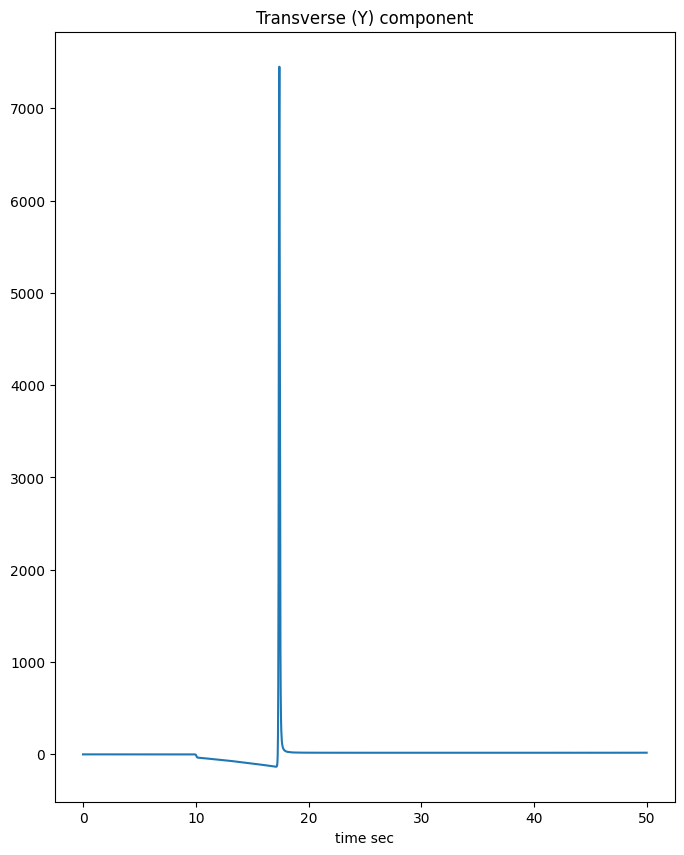

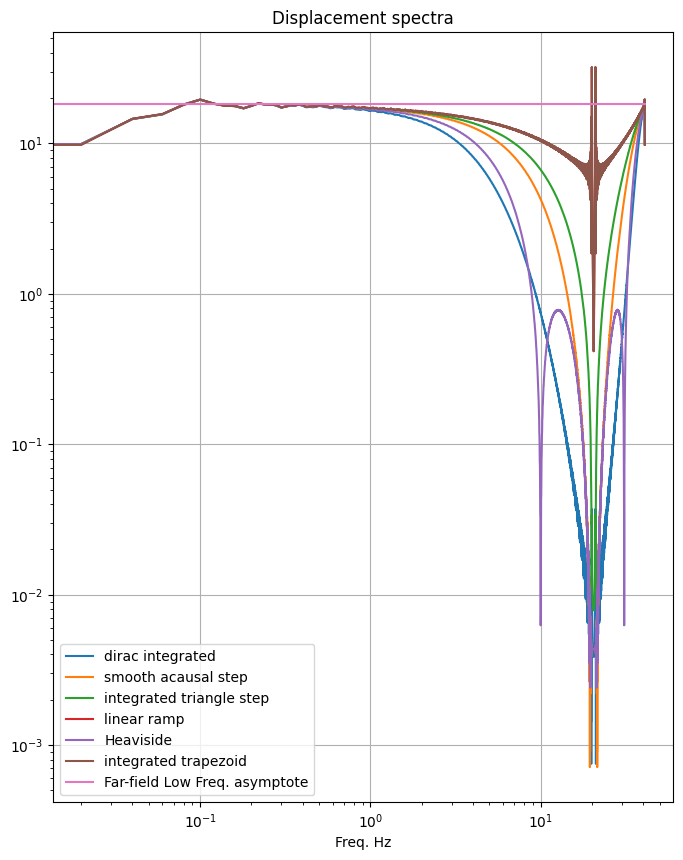

In [6]:
pt.figure(figsize=(8, 10))
#pt.subplot(2,1,1)
ier = pt.plot(t,sy_2[0,:])
pt.xlabel('time sec')
pt.title('Transverse (Y) component')
pt.show()

pt.figure(figsize=(8, 10))
#pt.subplot(2,1,2)
pt.xlabel('Freq. Hz')
pt.title('Displacement spectra')
pt.grid()
nfreq = t.size
df=1./t[-1]
norm = t.size
f = np.arange(0,nfreq)*df
pt.loglog(f, np.abs(np.fft.fft(sy_2[0,:]))/norm, f, np.abs(np.fft.fft(sy_4[0,:]))/norm,
          f, np.abs(np.fft.fft(sy_5[0,:]))/norm,f, np.abs(np.fft.fft(sy_7[0,:]))/norm,
          f, np.abs(np.fft.fft(sy_8[0,:]))/norm, f, np.abs(np.fft.fft(sy_0[0,:]))/norm,
          f, f*0.+LowFreq_asympt)
pt.legend(['dirac integrated','smooth acausal step','integrated triangle step',
           'linear ramp','Heaviside','integrated trapezoid','Far-field Low Freq. asymptote']);